In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from skimage.color import rgb2hsv

from seaborn import set_theme
set_theme()

In [2]:
cwd = os.getcwd()

In [3]:
train_img_dir = os.path.join(cwd, 'data', 'train', 'images')
valid_img_dir = os.path.join(cwd, 'data', 'validation', 'images')
test_img_dir = os.path.join(cwd, 'data', 'test', 'images')

train_img_names = os.listdir(train_img_dir)
valid_img_names = os.listdir(valid_img_dir)
test_img_names = os.listdir(test_img_dir)

n_train = len(train_img_names)
n_valid = len(valid_img_names)
n_test = len(test_img_names)

N = n_train + n_valid + n_test

train_img = np.zeros((n_train, 128, 128, 3))
valid_img = np.zeros((n_valid, 128, 128, 3))
test_img = np.zeros((n_test, 128, 128, 3))
train_img_hsv = np.zeros((n_train, 128, 128, 3))
valid_img_hsv = np.zeros((n_valid, 128, 128, 3))
test_img_hsv = np.zeros((n_test, 128, 128, 3))

In [4]:
for i, img_name in tqdm(enumerate(train_img_names), total=n_train):
    img = cv2.imread(os.path.join(train_img_dir, img_name))
    img_rs = cv2.resize(img, (128, 128))
    train_img[i] = img_rs / 255
    train_img_hsv[i] = rgb2hsv(img_rs)

for i, img_name in tqdm(enumerate(valid_img_names), total=n_valid):
    img = cv2.imread(os.path.join(valid_img_dir, img_name))
    img_rs = cv2.resize(img, (128, 128))
    valid_img[i] = img_rs / 255
    valid_img_hsv[i] = rgb2hsv(img_rs)

for i, img_name in tqdm(enumerate(test_img_names), total=n_test):
    img = cv2.imread(os.path.join(test_img_dir, img_name))
    img_rs = cv2.resize(img, (128, 128))
    test_img[i] = img_rs / 255
    test_img_hsv[i] = rgb2hsv(img_rs)

100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:02<00:00, 24.02it/s]


In [5]:
X_full = np.concatenate((train_img, valid_img, test_img), axis=0)
X_full_reshaped = X_full.reshape((N, 128*128*3))

X_full_hsv = np.concatenate((train_img_hsv, valid_img_hsv, test_img_hsv), axis=0)
X_full_hsv_reshaped = X_full_hsv.reshape((N, 128*128*3))

In [6]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_full_hsv_reshaped)

Text(0.5, 1.0, 'PCA')

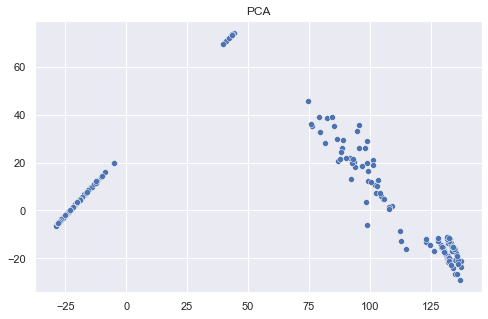

In [7]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1])
plt.title('PCA')

In [23]:
kmeans = KMeans(n_clusters=4)
kmeans_result = kmeans.fit_predict(pca_result)
sorted_cluster_labels = sorted([0, 1, 2, 3], reverse=True, key=lambda x: sum(kmeans_result == x))
cluster_names = dict(zip(['A', 'B', 'C', 'D'], sorted_cluster_labels))

Text(0.5, 1.0, 'PCA + KMeans')

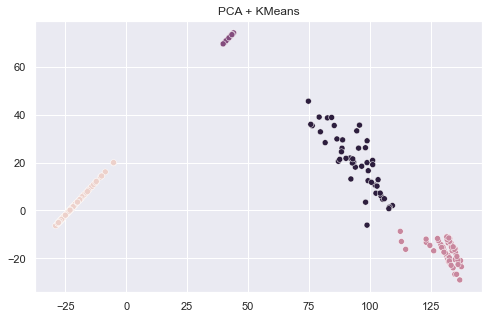

In [24]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=kmeans_result, legend=False)
plt.title('PCA + KMeans')

In [25]:
datasets_names = ['full', 'train', 'valid', 'test']
datasets = [kmeans_result,
            kmeans_result[:n_train],
            kmeans_result[n_train:n_train+n_valid],
            kmeans_result[n_train+n_valid:]]

for d_name, dataset in zip(datasets_names, datasets):
    print(f'Ratio of elements by cluster in {d_name} dataset:')
    N_ds = len(dataset)
    for c_name  in ['A', 'B', 'C', 'D']:
        n = sum(dataset == cluster_names[c_name])
        print(f'Number elements in cluster {c_name} is {n} - {n/N_ds*100:.2f}%')
    print('----------------------------------------------')

Ratio of elements by cluster in full dataset:
Number elements in cluster A is 599 - 81.50%
Number elements in cluster B is 73 - 9.93%
Number elements in cluster C is 47 - 6.39%
Number elements in cluster D is 16 - 2.18%
----------------------------------------------
Ratio of elements by cluster in train dataset:
Number elements in cluster A is 496 - 82.26%
Number elements in cluster B is 59 - 9.78%
Number elements in cluster C is 34 - 5.64%
Number elements in cluster D is 14 - 2.32%
----------------------------------------------
Ratio of elements by cluster in valid dataset:
Number elements in cluster A is 50 - 74.63%
Number elements in cluster B is 12 - 17.91%
Number elements in cluster C is 3 - 4.48%
Number elements in cluster D is 2 - 2.99%
----------------------------------------------
Ratio of elements by cluster in test dataset:
Number elements in cluster A is 53 - 81.54%
Number elements in cluster B is 2 - 3.08%
Number elements in cluster C is 10 - 15.38%
Number elements in clus

In [26]:
def plot_images(images, images_rows=2, images_cols=8):
    f, axarr = plt.subplots(images_rows, images_cols, figsize=(16,images_rows*2))
    for row in range(images_rows):
        for col in range(images_cols):
            image_id = row*images_cols + col
            image = images[image_id]
            ax = axarr[row,col]
            ax.axis('off')
            ax.imshow(image, norm=None, cmap=None)

### Images of cluster A

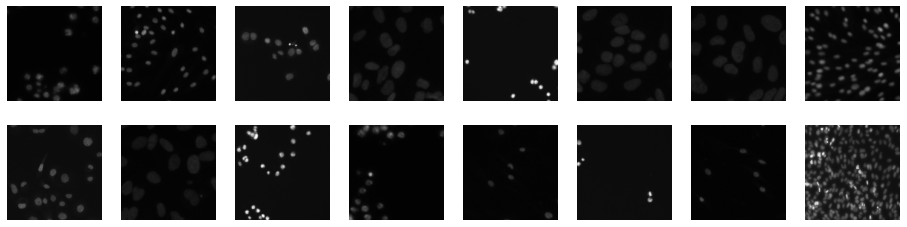

In [27]:
plot_images(X_full[kmeans_result==cluster_names['A']])

### Images of cluster B

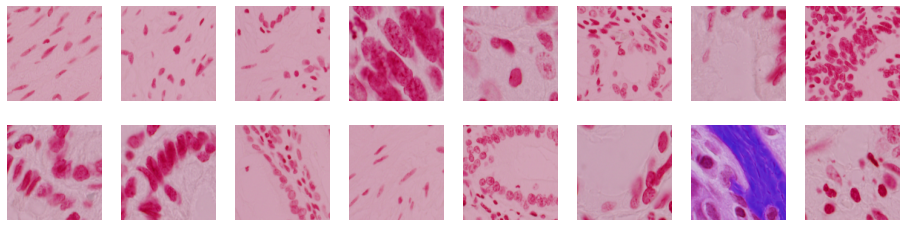

In [28]:
plot_images(X_full[kmeans_result==cluster_names['B']])

### Images of cluster C

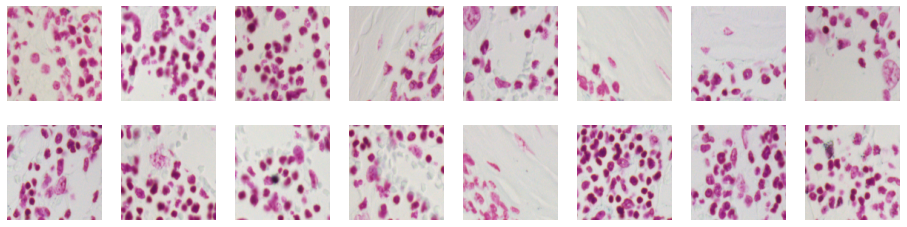

In [29]:
plot_images(X_full[kmeans_result==cluster_names['C']])

### Images of cluster D

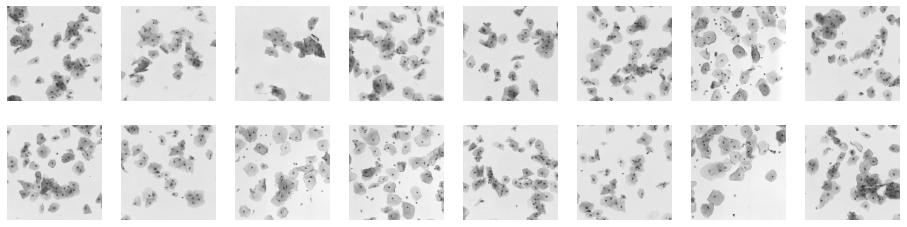

In [30]:
plot_images(X_full[kmeans_result==cluster_names['D']])

In [22]:
kmeans_train = kmeans_result[:n_train]

names_by_cluster = {'A':0, 'B':0, 'C':0, 'D':0,}
for c in ['A', 'B', 'C', 'D']:
    names_by_cluster[c] = [name for name, val in zip(train_img_names, (kmeans_train == cluster_names[c])) if val]

for c in ['A', 'B', 'C', 'D']:
    df = pd.DataFrame(names_by_cluster[c])
    path = os.path.join(cwd, 'data', 'train', f'cluster_{c}.csv')
    df.to_csv(path, header=False, index=False)